In [1]:
from neurodiffeq import diff
from neurodiffeq.pde import ExampleGenerator2D, make_animation
from neurodiffeq.networks import FCNN
from torch import optim, nn

import numpy as np
import torch
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d  import Axes3D

In [2]:
class Monitor2D:
    def __init__(self, xy_min, xy_max, check_every=100):
        self.check_every = check_every
        self.fig = plt.figure(figsize=(20, 8))
        self.ax1 = self.fig.add_subplot(121)
        self.ax2 = self.fig.add_subplot(122)
        self.cb1 = None
        # input for neural network
        gen = ExampleGenerator2D([32, 32], xy_min, xy_max, method='equally-spaced')
        xs_ann, ys_ann = gen.get_examples()
        self.xs_ann, self.ys_ann = xs_ann.reshape(-1, 1), ys_ann.reshape(-1, 1)
        self.xy_ann = torch.cat((self.xs_ann, self.ys_ann), 1)

    def check(self, net, pde, condition, loss_history):
#         us = net(self.xy_ann)
#         us = condition.enforce(us, self.xs_ann, self.ys_ann)
        us = condition.enforce(net, self.xs_ann, self.ys_ann)
        us = us.detach().numpy().flatten()

        self.ax1.clear()
        cax1 = self.ax1.matshow(us.reshape((32, 32)), cmap='hot', interpolation='nearest')
        if self.cb1: self.cb1.remove()
        self.cb1 = self.fig.colorbar(cax1, ax=self.ax1)
        self.ax1.set_title('u(x, y)')

        self.ax2.clear()
        self.ax2.plot(loss_history['train'], label='training loss')
        self.ax2.plot(loss_history['valid'], label='validation loss')
        self.ax2.set_title('loss during training')
        self.ax2.set_ylabel('loss')
        self.ax2.set_xlabel('epochs')
        self.ax2.set_yscale('log')
        self.ax2.legend()

        self.fig.canvas.draw()

In [3]:
def solve2D(
        pde, condition, xy_min, xy_max,
        net=None, train_generator=None, shuffle=True, valid_generator=None, optimizer=None, criterion=None, batch_size=32,
        max_epochs=1000,
        monitor=None, return_internal=False
):
    # default values
    if not net:
        net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Tanh)
    if not train_generator:
        train_generator = ExampleGenerator2D([32, 32], xy_min, xy_max, method='equally-spaced-noisy')
    if not valid_generator:
        valid_generator = ExampleGenerator2D([32, 32], xy_min, xy_max, method='equally-spaced')
    if not optimizer:
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    if not criterion:
        criterion = nn.MSELoss()

    if return_internal:
        internal = {
            'net': net,
            'condition': condition,
            'train_generator': train_generator,
            'valid_generator': valid_generator,
            'optimizer': optimizer,
            'criterion': criterion
        }

    n_examples_train = train_generator.size
    n_examples_valid = valid_generator.size
    train_zeros = torch.zeros(batch_size)
    valid_zeros = torch.zeros(n_examples_valid)

    loss_history = {'train': [], 'valid': []}

    for epoch in range(max_epochs):
        train_loss_epoch = 0.0

        train_examples_x, train_examples_y = train_generator.get_examples()
        train_examples_x, train_examples_y = train_examples_x.reshape((-1, 1)), train_examples_y.reshape((-1, 1))
        idx = np.random.permutation(n_examples_train) if shuffle else np.arange(n_examples_train)
        batch_start, batch_end = 0, batch_size
        while batch_start < n_examples_train:

            if batch_end > n_examples_train:
                batch_end = n_examples_train
            batch_idx = idx[batch_start:batch_end]
            xs, ys = train_examples_x[batch_idx], train_examples_y[batch_idx]

#             xys = torch.cat((xs, ys), 1)
#             us = net(xys)
#             us = condition.enforce(us, xs, ys)
            us = condition.enforce(net, xs, ys)

            Fuxy = pde(us, xs, ys)
            loss = criterion(Fuxy, train_zeros)
            train_loss_epoch += loss.item() * (batch_end-batch_start)/n_examples_train

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_start += batch_size
            batch_end += batch_size

        loss_history['train'].append(train_loss_epoch)

        # calculate the validation loss
        valid_examples_x, valid_examples_y = valid_generator.get_examples()
        xs, ys = valid_examples_x.reshape((-1, 1)), valid_examples_y.reshape((-1, 1))
#         xys = torch.cat((xs, ys), 1)
#         us = net(xys)
#         us = condition.enforce(us, xs, ys)
        us = condition.enforce(net, xs, ys)
        Fuxy = pde(us, xs, ys)
        valid_loss_epoch = criterion(Fuxy, valid_zeros).item()

        loss_history['valid'].append(valid_loss_epoch)

        if monitor and epoch % monitor.check_every == 0:
            monitor.check(net, pde, condition, loss_history)

    def solution(xs, ys, as_type='tf'):
        original_shape = xs.shape
        if not isinstance(xs, torch.Tensor): xs = torch.tensor([xs], dtype=torch.float32)
        if not isinstance(ys, torch.Tensor): ys = torch.tensor([ys], dtype=torch.float32)
        xs, ys = xs.reshape(-1, 1), ys.reshape(-1, 1)
#         xys = torch.cat((xs, ys), 1)
#         us = net(xys)
#         us = condition.enforce(us, xs, ys)
        us = condition.enforce(net, xs, ys)
        if   as_type == 'tf':
            return us.reshape(original_shape)
        elif as_type == 'np':
            return us.detach().numpy().reshape(original_shape)
        else:
            raise ValueError("The valid return types are 'tf' and 'np'.")

    if return_internal:
        return solution, loss_history, internal
    else:
        return solution, loss_history

It is possible to solve PDE's with mixed boundary conditions. For example, if we want to solve a PDE

$$
\frac{\partial^2}{\partial x^2}u + \frac{\partial^2}{\partial y^2}u = f(x, y)
$$

with the following boundary condition (a square, Dirichlet boundary on 3 edges and Neumann boundary on the other):

$$
u(0, y) = f_0(y), u(1, y) = f_1(y), u(x, 0) = g_0(x) \\
\frac{\partial}{\partial x}u(x, 1) = g_1(x)
$$

In this case, to satisfy the boundary conditions, we can formulate the trial solution as (where $N(x, y, \vec{p})$ is the output of the neural network):

$$
u_t(x,y) = B(x, y) + x(1−x)y[N(x, y, \vec{p}) − N(x, 1, \vec{p})− \frac{\partial}{\partial y}N(x, 1, \vec{p})] \\
B(x, y) =  (1−x)f_0(y) + xf_1(y) + g_0(x) − [(1−x)g_0(0) + xg_0(1)] + y\{g_1(x) − [(1−x)g_1(0) + xg_1(1)]\}
$$

Notes:
* The trial solution is different from the ones we used in Dirichlet boundary conditions in the sense that we have a neural network output other than $N(x, y, \vec{p})$ (the $N(x, 1, \vec{p})$ term), the API of the `enforce` function as I wrote cannot handle this, so I made some monkey patch above.

In [4]:
class Mixed2D_ASpecialCase:
    
    def __init__(self, x_min, x_min_val, x_max, x_max_val, y_min, y_min_val, y_max, y_max_prime):
        self.x_min, self.x_min_val = x_min, x_min_val
        self.x_max, self.x_max_val = x_max, x_max_val
        self.y_min, self.y_min_val = y_min, y_min_val
        self.y_max, self.y_max_prime = y_max, y_max_prime

    def enforce(self, net, x, y):
        xys = torch.cat((x, y), 1)
        uxy = net(xys)
        
        x_ones = torch.ones_like(x, requires_grad=True)
        y_ones = torch.ones_like(y, requires_grad=True)
        y_ones_max = self.y_max * y_ones
        x1s  = torch.cat((x, y_ones_max), 1)
        ux1  = net(x1s)
        
        x_tilde = (x-self.x_min) / (self.x_max-self.x_min)
        y_tilde = (y-self.y_min) / (self.y_max-self.y_min)

        Bxy = (1-x_tilde)*self.x_min_val(y) + x_tilde*self.x_max_val(y) + self.y_min_val(x_tilde) - (
            (1-x_tilde) * self.y_min_val(self.x_min * x_ones) +
            (x_tilde)   * self.y_min_val(self.x_max * x_ones)
        ) + y_tilde * ( self.y_max_prime(x) - (
            (1-x_tilde) * self.y_max_prime(self.x_min * y_ones) +
            (x_tilde)   * self.y_max_prime(self.x_max * y_ones)
        ))
        return Bxy + x_tilde*(1-x_tilde)*y_tilde*(uxy - ux1 - diff(ux1, y_ones_max))

We can test this method with the following problem:

$$
\frac{\partial^2}{\partial x^2}u + \frac{\partial^2}{\partial y^2}u = (2 - \pi^2 y^2)\sin(\pi x) \\
u(0, y) = 0, u(1, y) = 0, u(x, 0) = 0 \\
\frac{\partial}{\partial y}u(x, 1) = 2\sin(\pi x)
$$

<IPython.core.display.Javascript object>


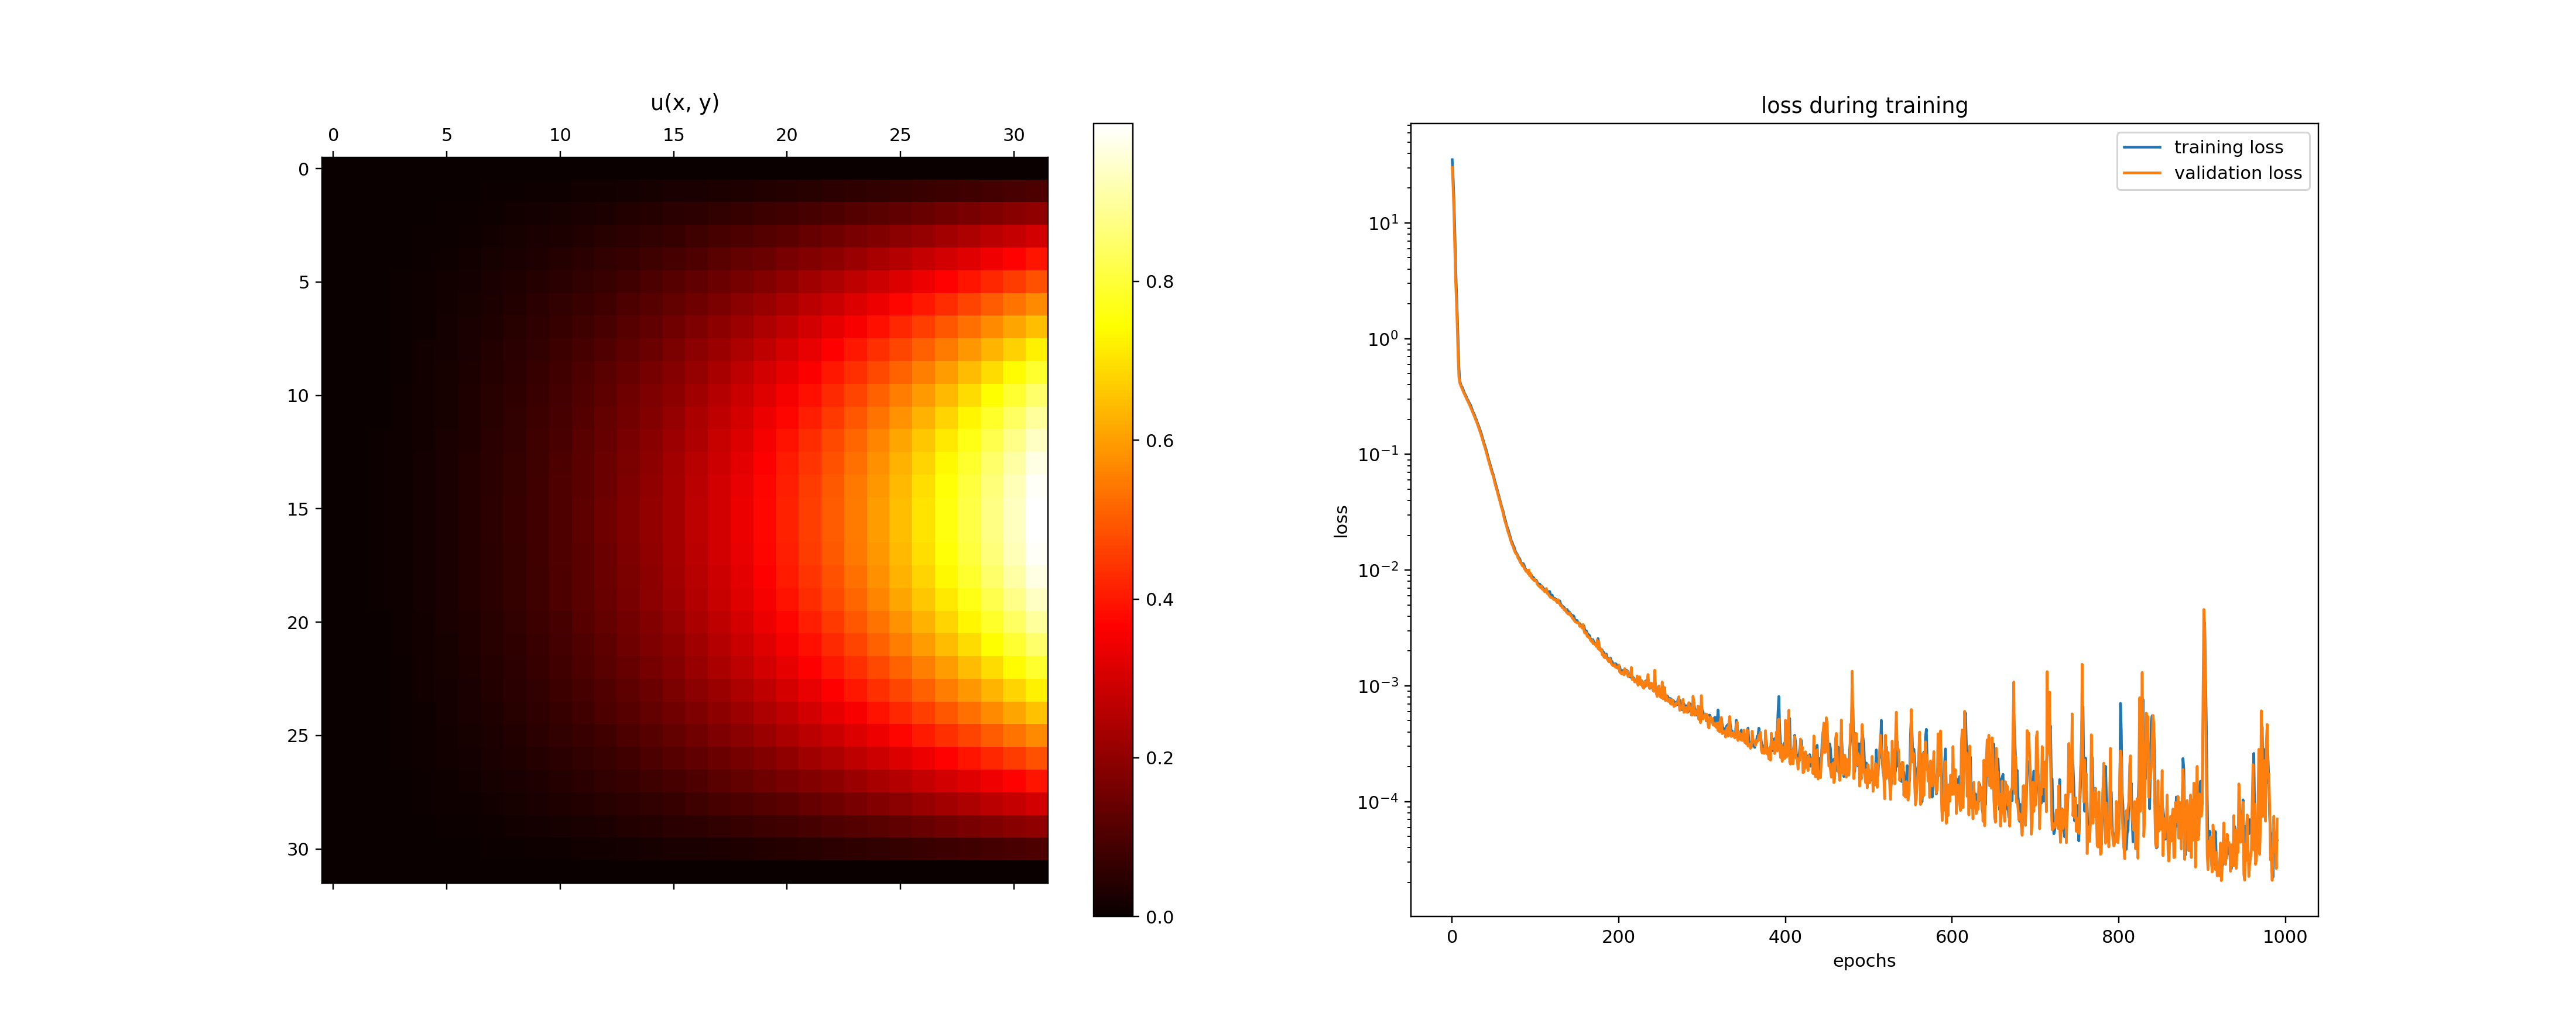

In [5]:
%matplotlib notebook
some_pde = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - (2 - np.pi**2 * y**2) * torch.sin(np.pi * x)
BC = Mixed2D_ASpecialCase(
    x_min=0, x_min_val=lambda y: 0, 
    x_max=1, x_max_val=lambda y: 0, 
    y_min=0, y_min_val=lambda x: 0, 
    y_max=1, y_max_prime=lambda x: 2 * torch.sin(np.pi * x)
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_some_pde, _ = solve2D(
    pde=some_pde, condition=BC, xy_min=[0, 0], xy_max=[1, 1],
    net=net, max_epochs=1000, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [1, 1], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[1, 1])
)

In [9]:
# a helper function to plot surface
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.set_proj_type('ortho')
    plt.show()

<IPython.core.display.Javascript object>


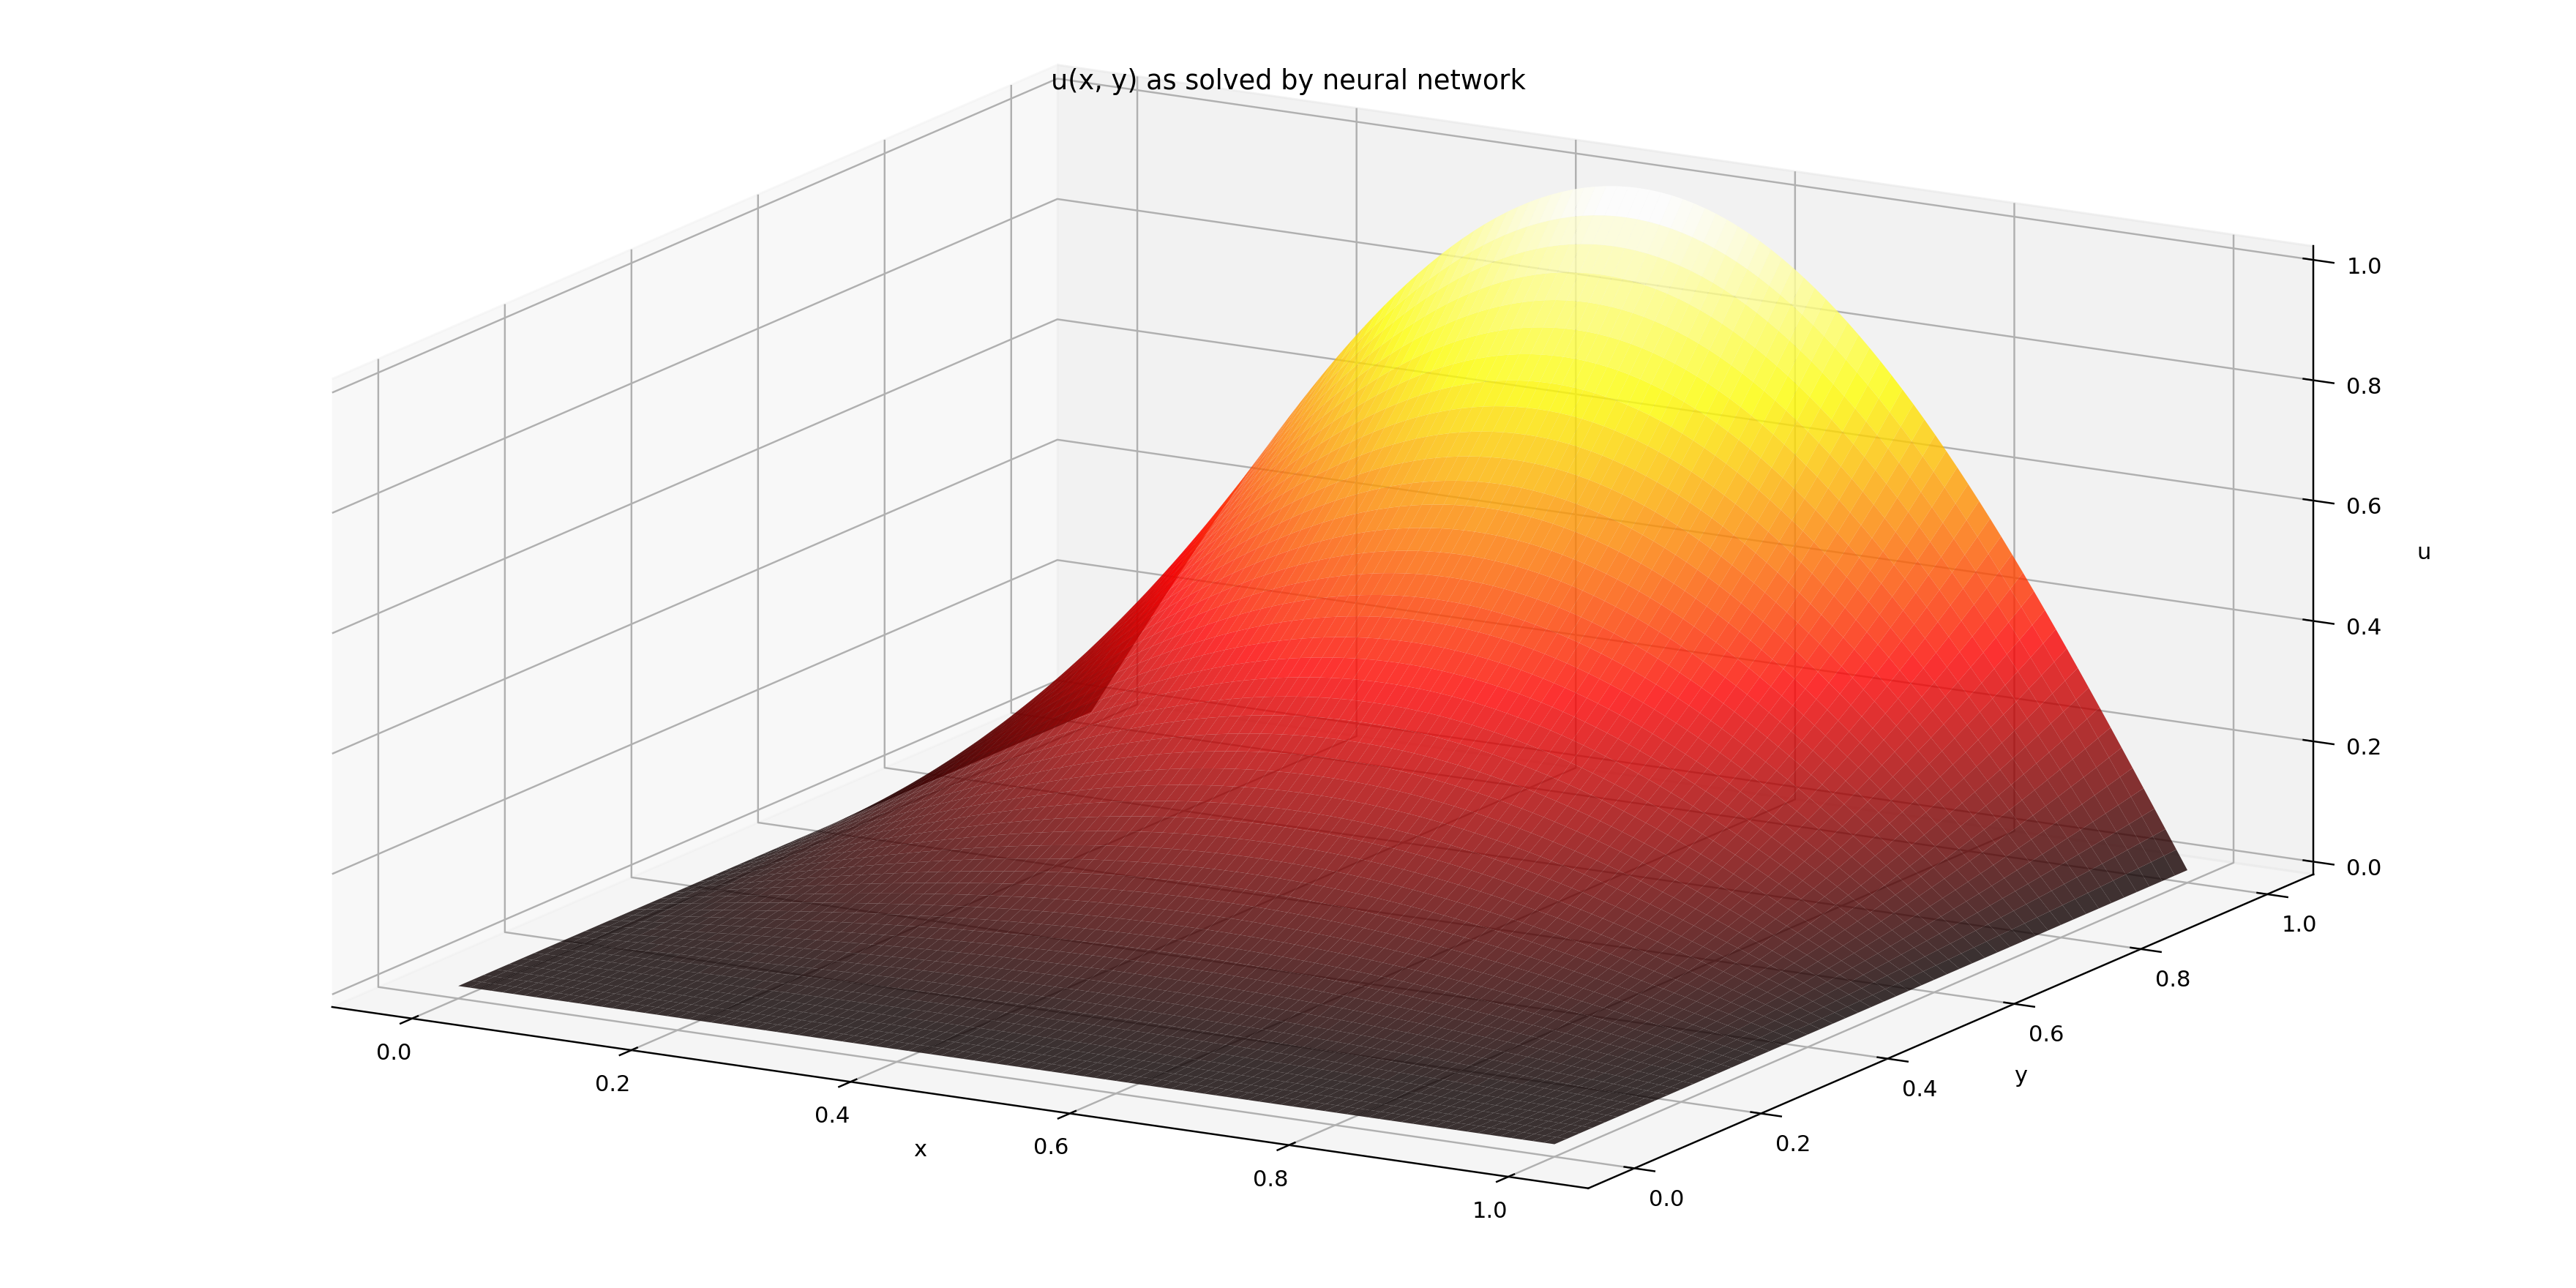

In [8]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net_some_pde(xx, yy, as_type='np')
plt_surf(xx, yy, sol_net, title='u(x, y) as solved by neural network')

We can compare $\displaystyle\frac{\partial}{\partial y}u(x, 1)$ with $2\sin(\pi x)$ to show that the Neumann boundary condition is indeed satisfied:

<IPython.core.display.Javascript object>


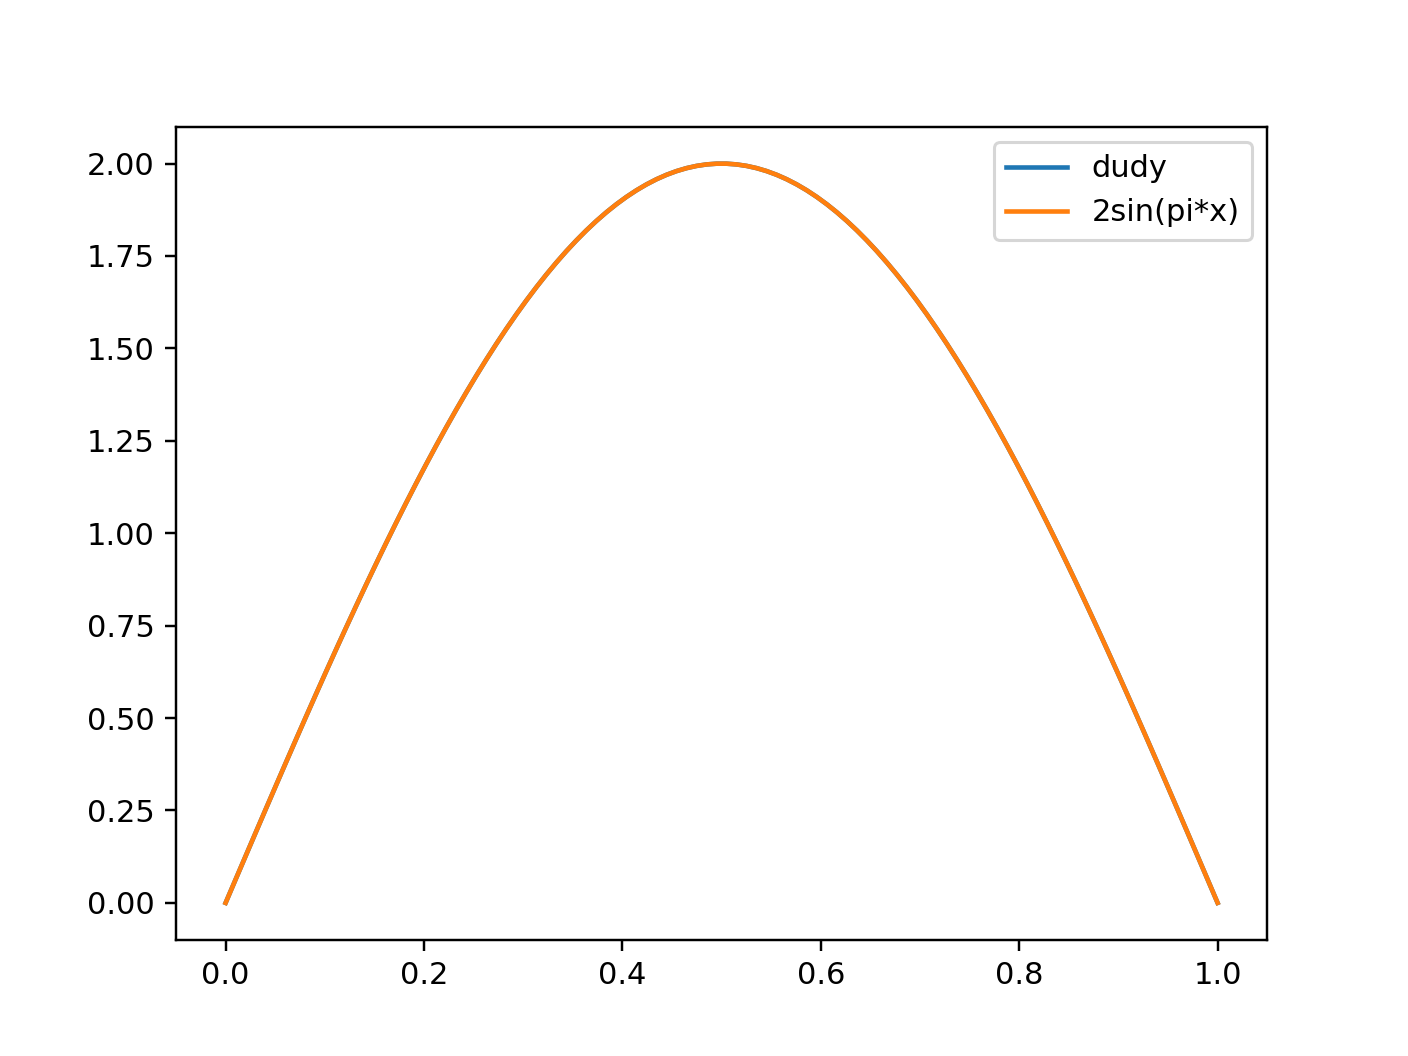

In [9]:
xs, ys = torch.linspace(0, 1, 100, requires_grad=True), torch.ones(100, requires_grad=True)
u_at_neumann_boundary = solution_neural_net_some_pde(xs, ys)
dudy_at_neumann_boundary = diff(u_at_neumann_boundary, ys)
plt.plot(
    xs.detach().numpy(),
    dudy_at_neumann_boundary.detach().numpy(), 
    label='dudy'
)
plt.plot(
    xs.detach().numpy(),
    2*np.sin(np.pi*xs.detach().numpy()), 
    label='2sin(pi*x)'
)
plt.legend()
plt.show()

The analytical solution is $u = y^2\sin(\pi x)$. The residual of the neural network solution is as follows:

<IPython.core.display.Javascript object>


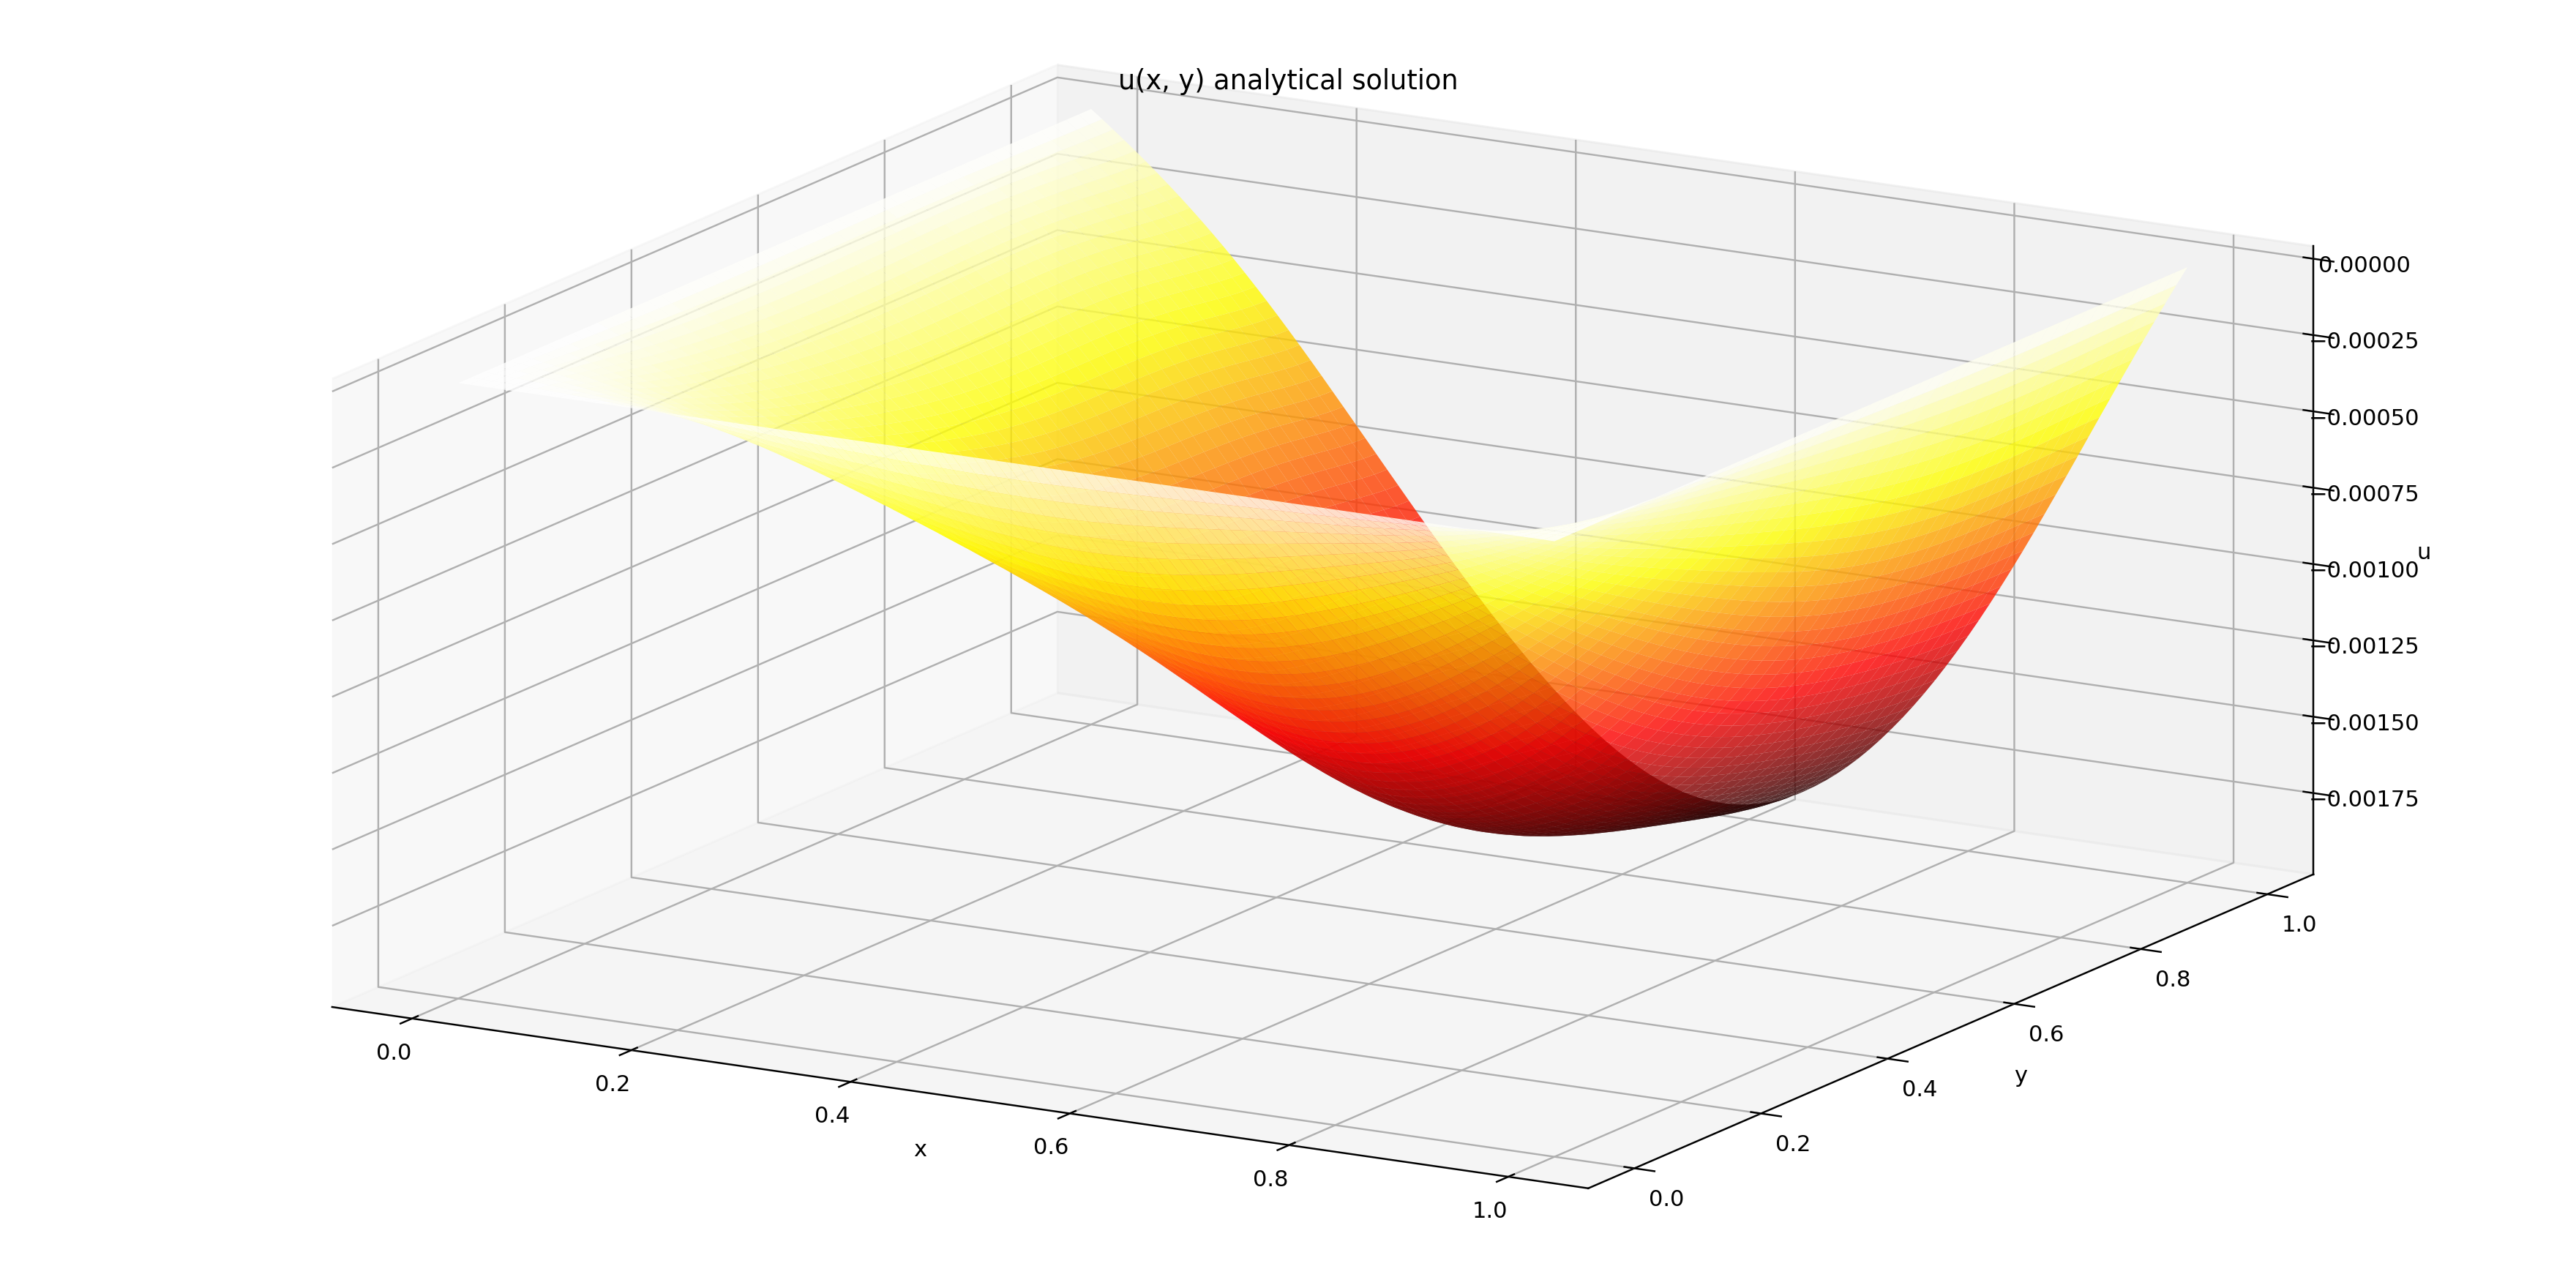

In [10]:
def solution_analytical_some_pde(x, y):
    return y**2 * np.sin(np.pi * x)
sol_ana = solution_analytical_some_pde(xx, yy)
sol_net = solution_neural_net_some_pde(xx, yy, as_type='np')
plt_surf(xx, yy, sol_ana-sol_net, title='u(x, y) analytical solution')

In [21]:
# TODO: There is a bug inside this trial solution. Now it only works with x \from [0, 1]

class DirichletNeumannIBVP1D:
    
    def __init__(self, x_min, x_min_val, x_max, x_max_prime, t_min_val, t_min=0.0):
        self.x_min, self.x_min_val = x_min, x_min_val
        self.x_max, self.x_max_prime = x_max, x_max_prime
        self.t_min, self.t_min_val = t_min, t_min_val

    def enforce(self, u, x, t):
        xts = torch.cat((x, t), 1)
        uxt = net(xts)
        
        x_ones = torch.ones_like(x, requires_grad=True)
        t_ones = torch.ones_like(t, requires_grad=True)
        x_ones_max = self.x_max * x_ones
        t_ones_min = self.t_min * t_ones
        xmaxts  = torch.cat((x_ones_max, t), 1)
        uxmaxt  = net(xmaxts)
        
        x_tilde = (x-self.x_min) / (self.x_max-self.x_min)
        t_tilde = t-self.t_min
        
        Axt = (self.x_min_val(t) - self.x_min_val(t_ones_min)) + self.t_min_val(x) + \
            x_tilde * (self.x_max-self.x_min) * (self.x_max_prime(t) - self.x_max_prime(t_ones_min))
        return Axt + x_tilde*(1-torch.exp(-t_tilde))*( 
            uxt - (self.x_max-self.x_min)*diff(uxmaxt, x_ones_max) - uxmaxt
        )

solve
$$
\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0
$$

for
$$
u|_{x=0} = 0 \\
\frac{\partial u}{\partial x}|_{x=L} = -\frac{\pi}{L}\exp(\frac{-k\pi^2 t}{L^2}) \\
u|_{t=0} = \sin(\pi \frac{x}{L})
$$

In this case, the analytical solution is

$$
u(x, t) = \sin(\pi \frac{x}{L}) \exp(\frac{-k \pi^2 t}{L^2})
$$

<IPython.core.display.Javascript object>


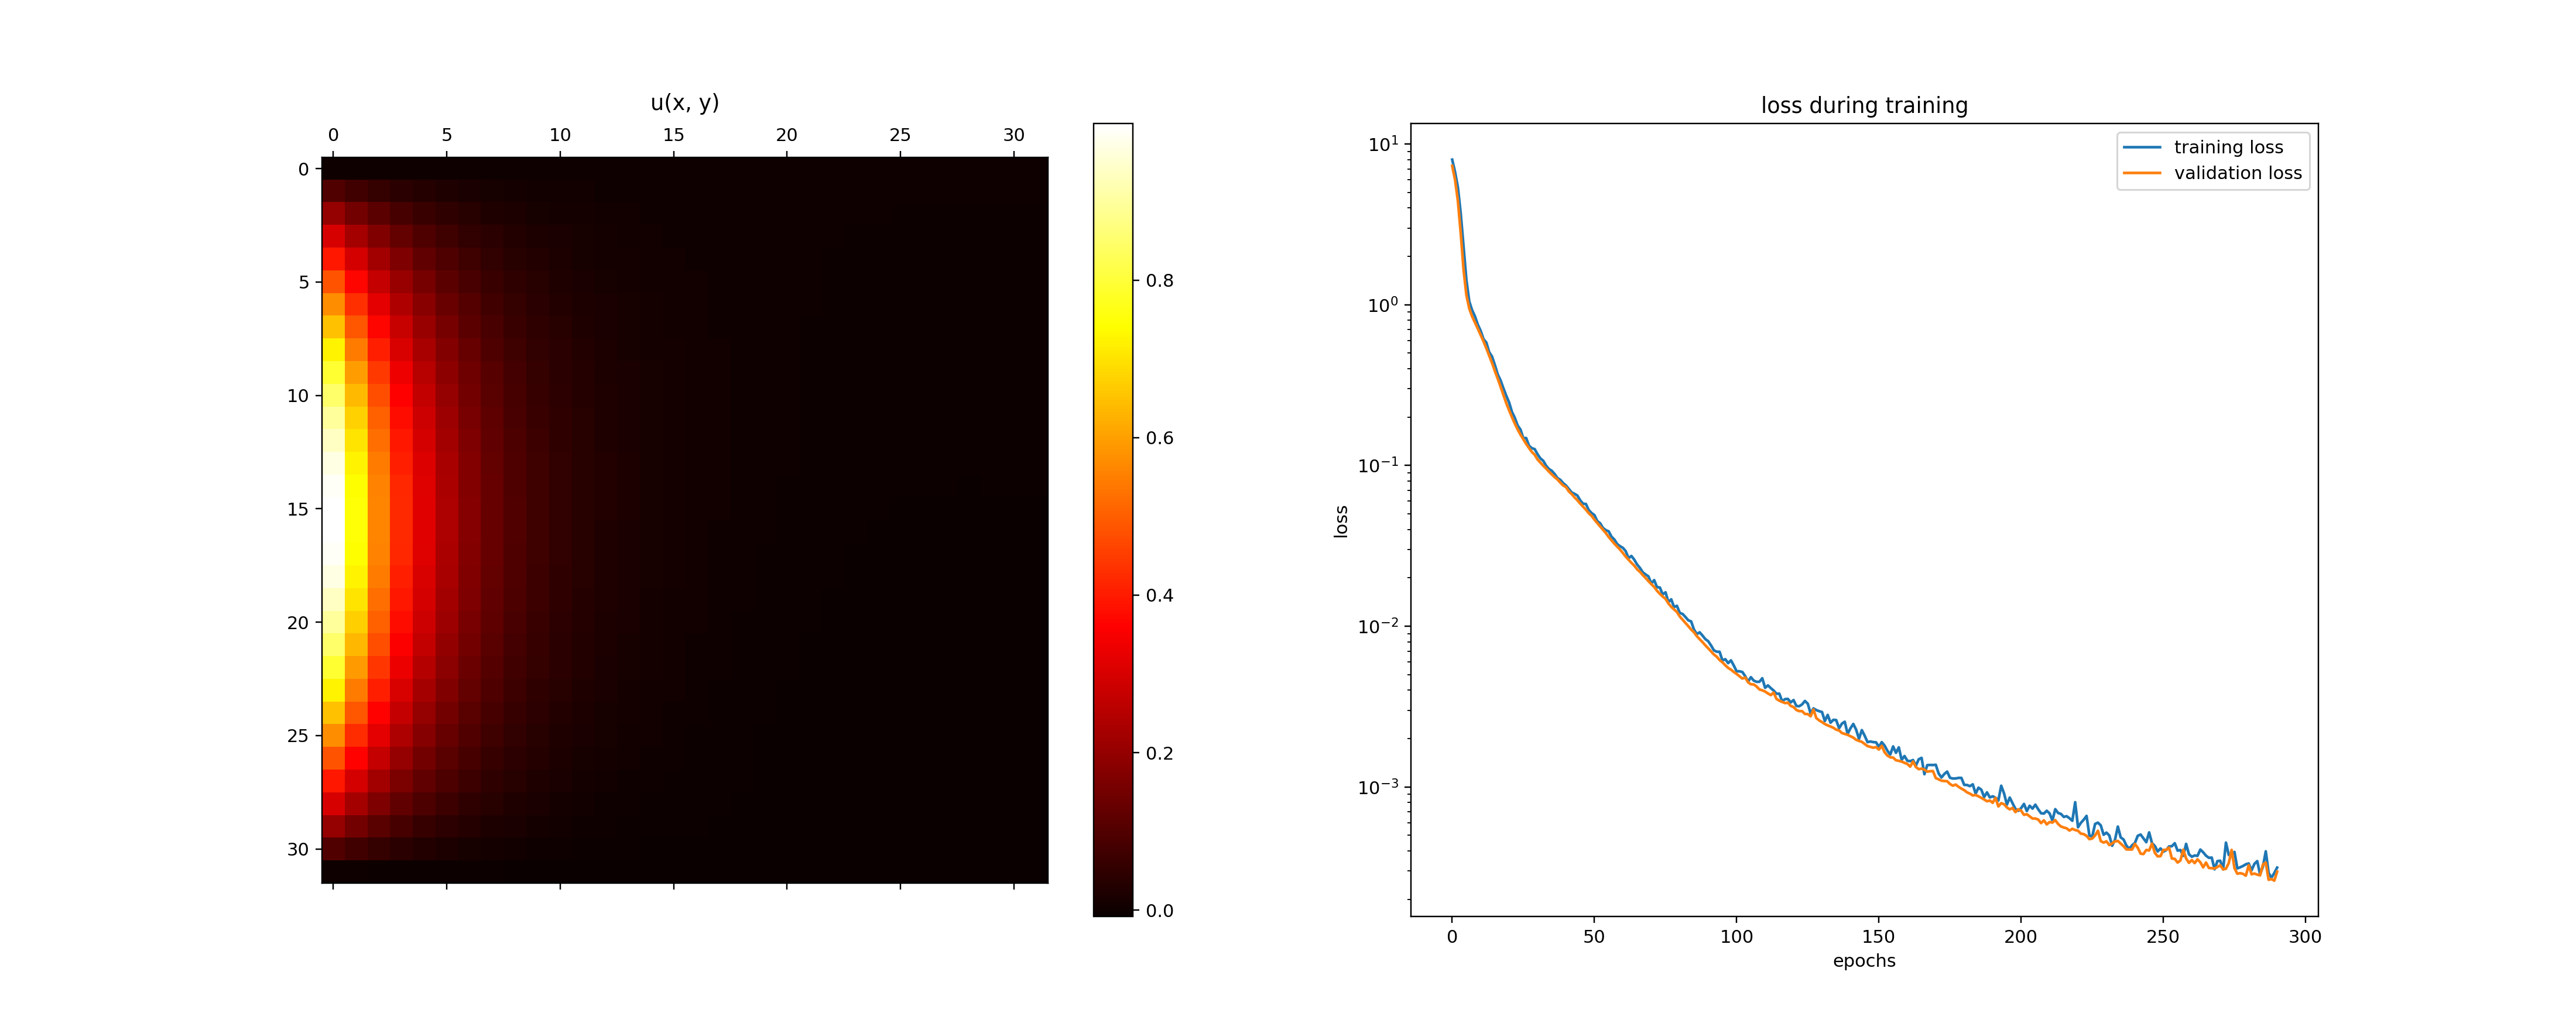

In [22]:
%matplotlib notebook
k, L, T = 0.3, 1, 3
heat = lambda u, x, t: diff(u, t) - k * diff(u, x, order=2)


BC = DirichletNeumannIBVP1D(
    x_min=0, x_min_val=lambda t: 0, 
    x_max=L, x_max_prime=lambda t: -np.pi/L * torch.exp(-k*np.pi**2*t/L**2),
    t_min=0, t_min_val=lambda x: torch.sin(np.pi * x / L)
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_heat, _ = solve2D(
    pde=heat, condition=BC, xy_min=[0, 0], xy_max=[L, T],
    net=net, max_epochs=300, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [L, T], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[L, T])
)

<IPython.core.display.Javascript object>


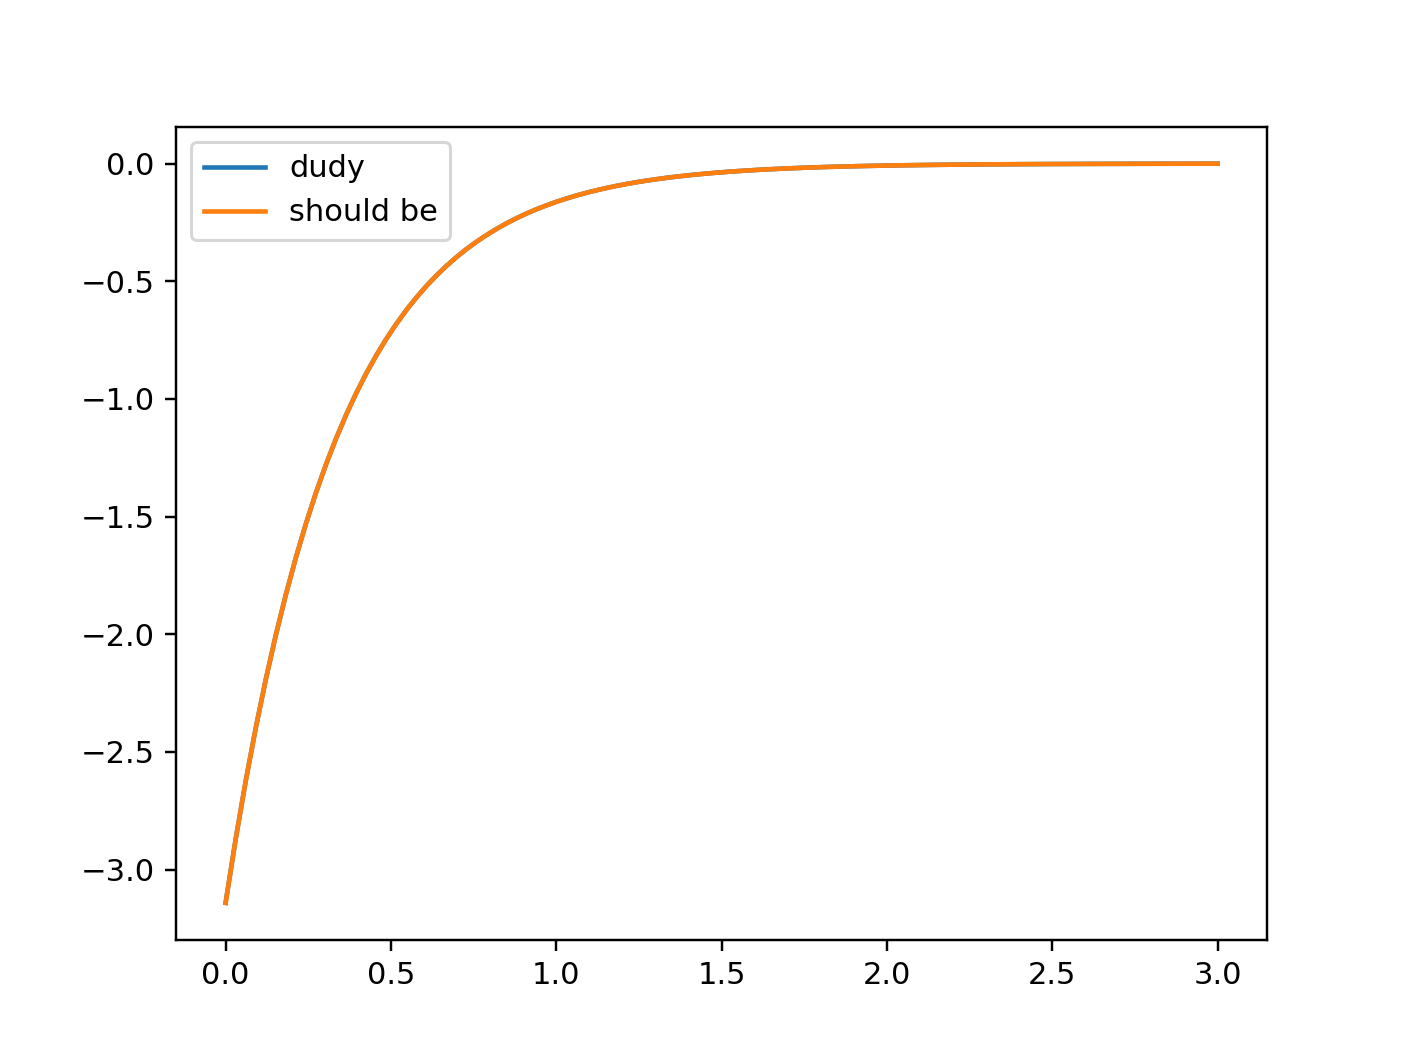

In [23]:
xs, ts = L * torch.ones(100, requires_grad=True), torch.linspace(0, T, 100, requires_grad=True)
u_at_neumann_boundary = solution_neural_net_heat(xs, ts)
dudx_at_neumann_boundary = diff(u_at_neumann_boundary, xs)
plt.plot(
    ts.detach().numpy(),
    dudx_at_neumann_boundary.detach().numpy(), 
    label='dudy'
)
plt.plot(
    ts.detach().numpy(),
    -np.pi/L * np.exp(-k*np.pi**2*ts.detach().numpy()/L**2),
    label='should be'
)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


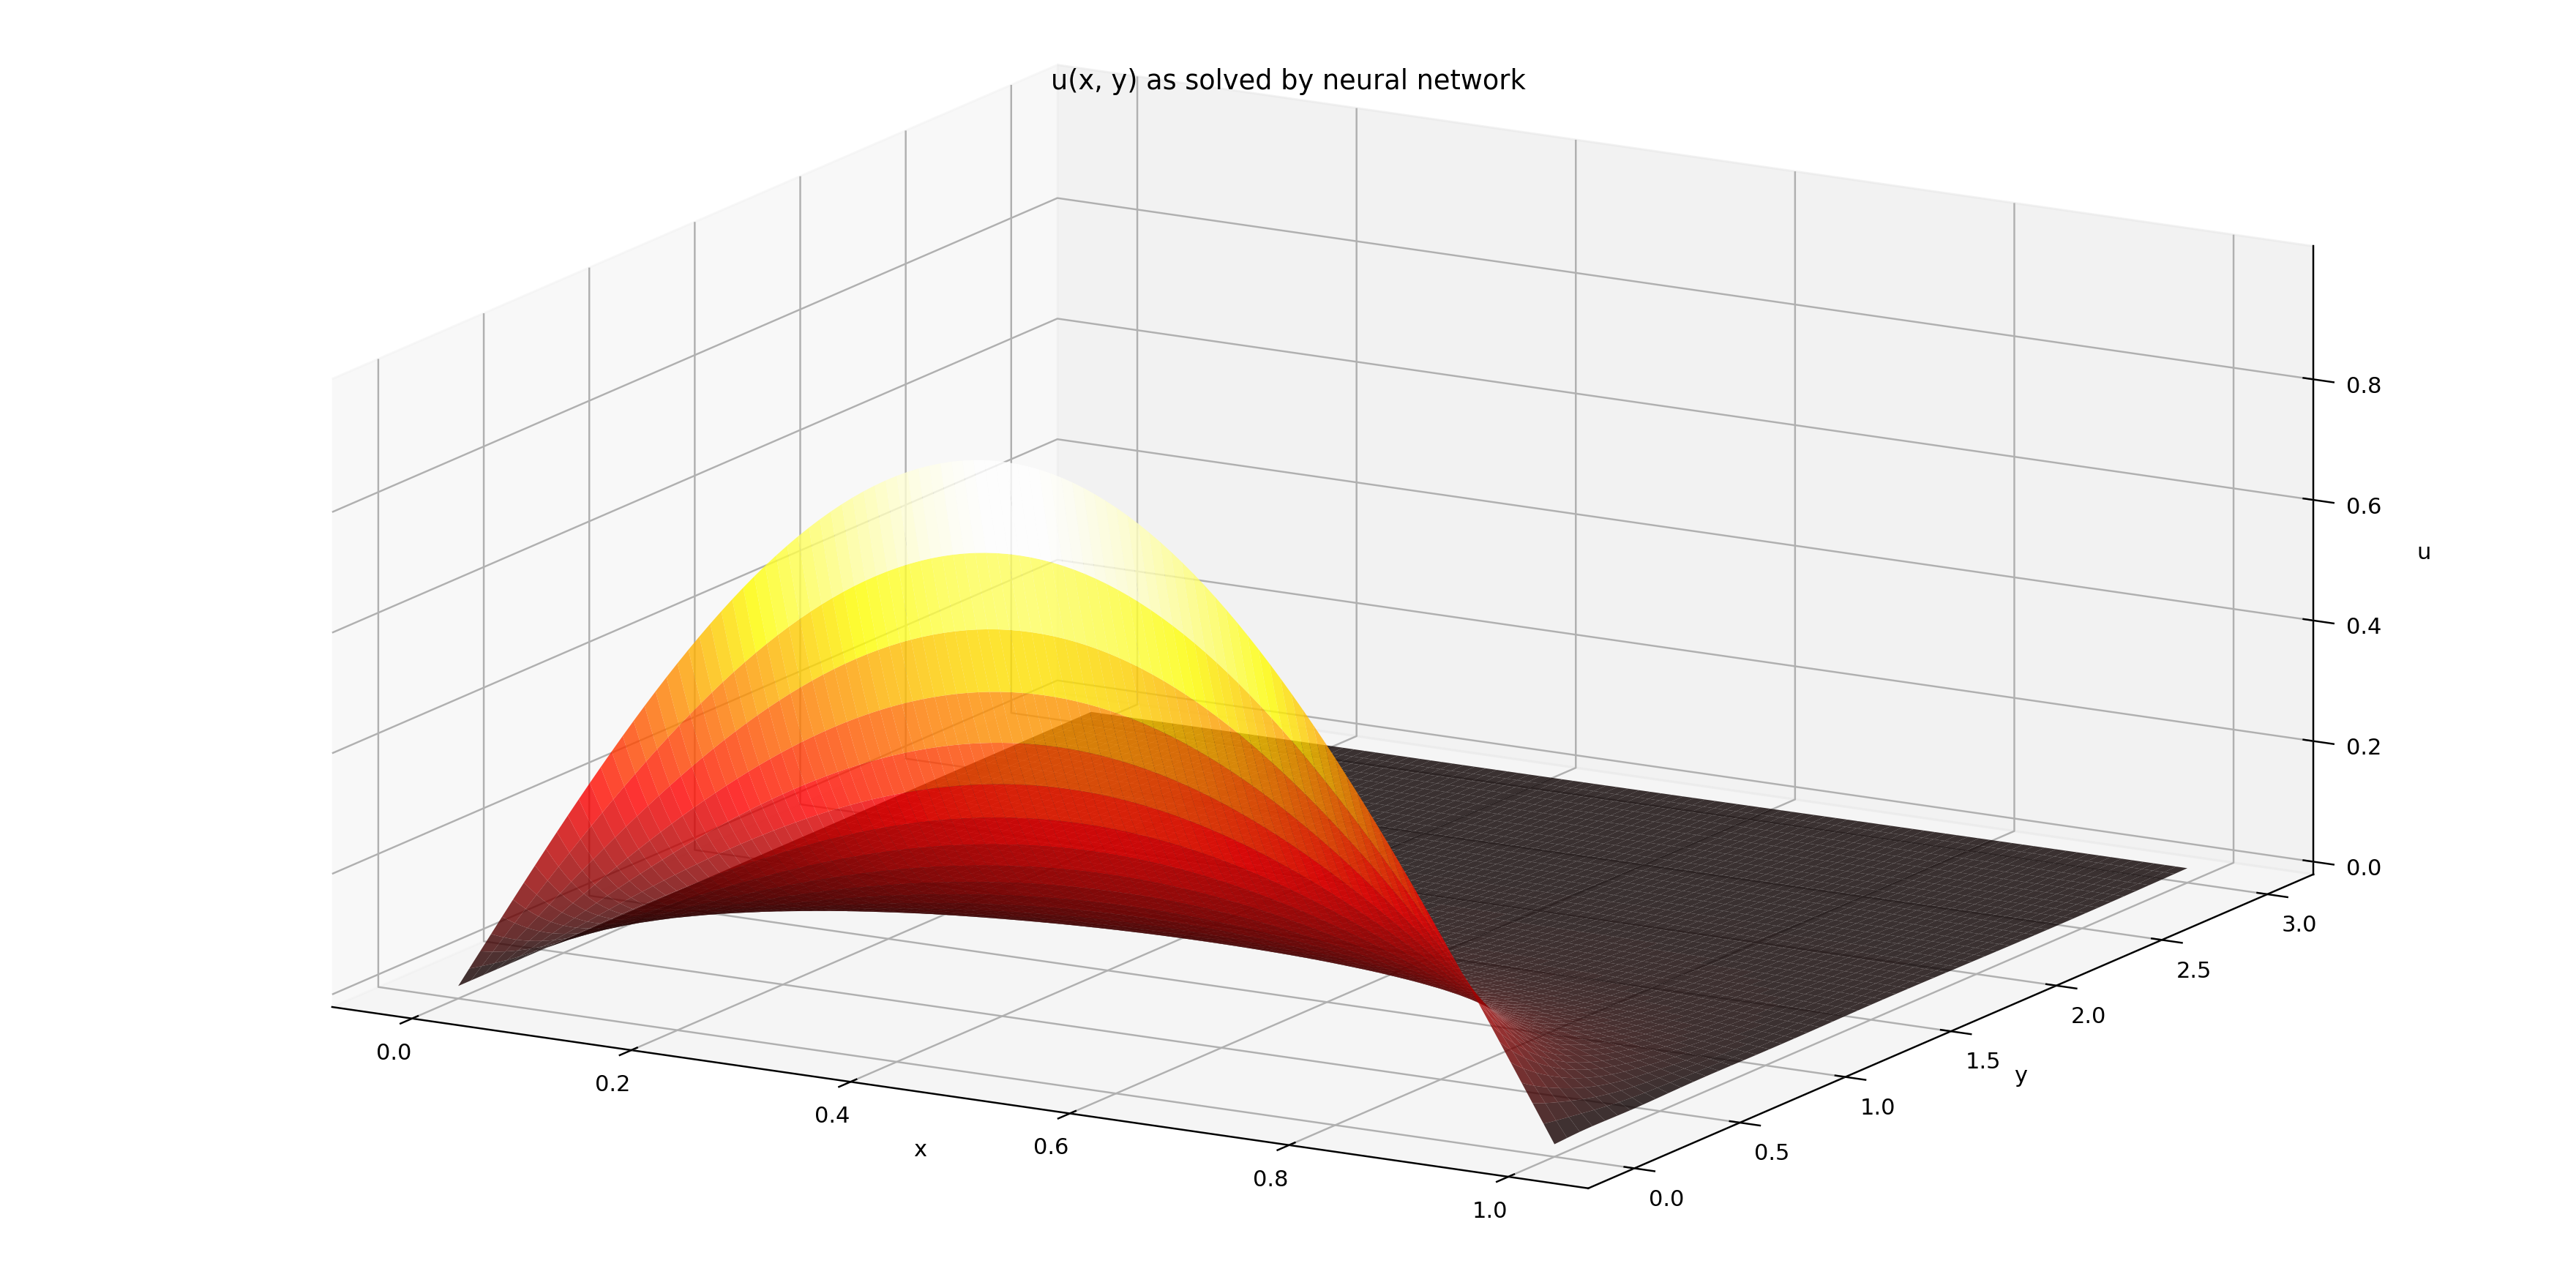

In [24]:
xs, ts = np.linspace(0, L, 101), np.linspace(0, T, 101)
xx, tt = np.meshgrid(xs, ts)
sol_net = solution_neural_net_heat(xx, tt, as_type='np')
plt_surf(xx, tt, sol_net, title='u(x, y) as solved by neural network')

<IPython.core.display.Javascript object>


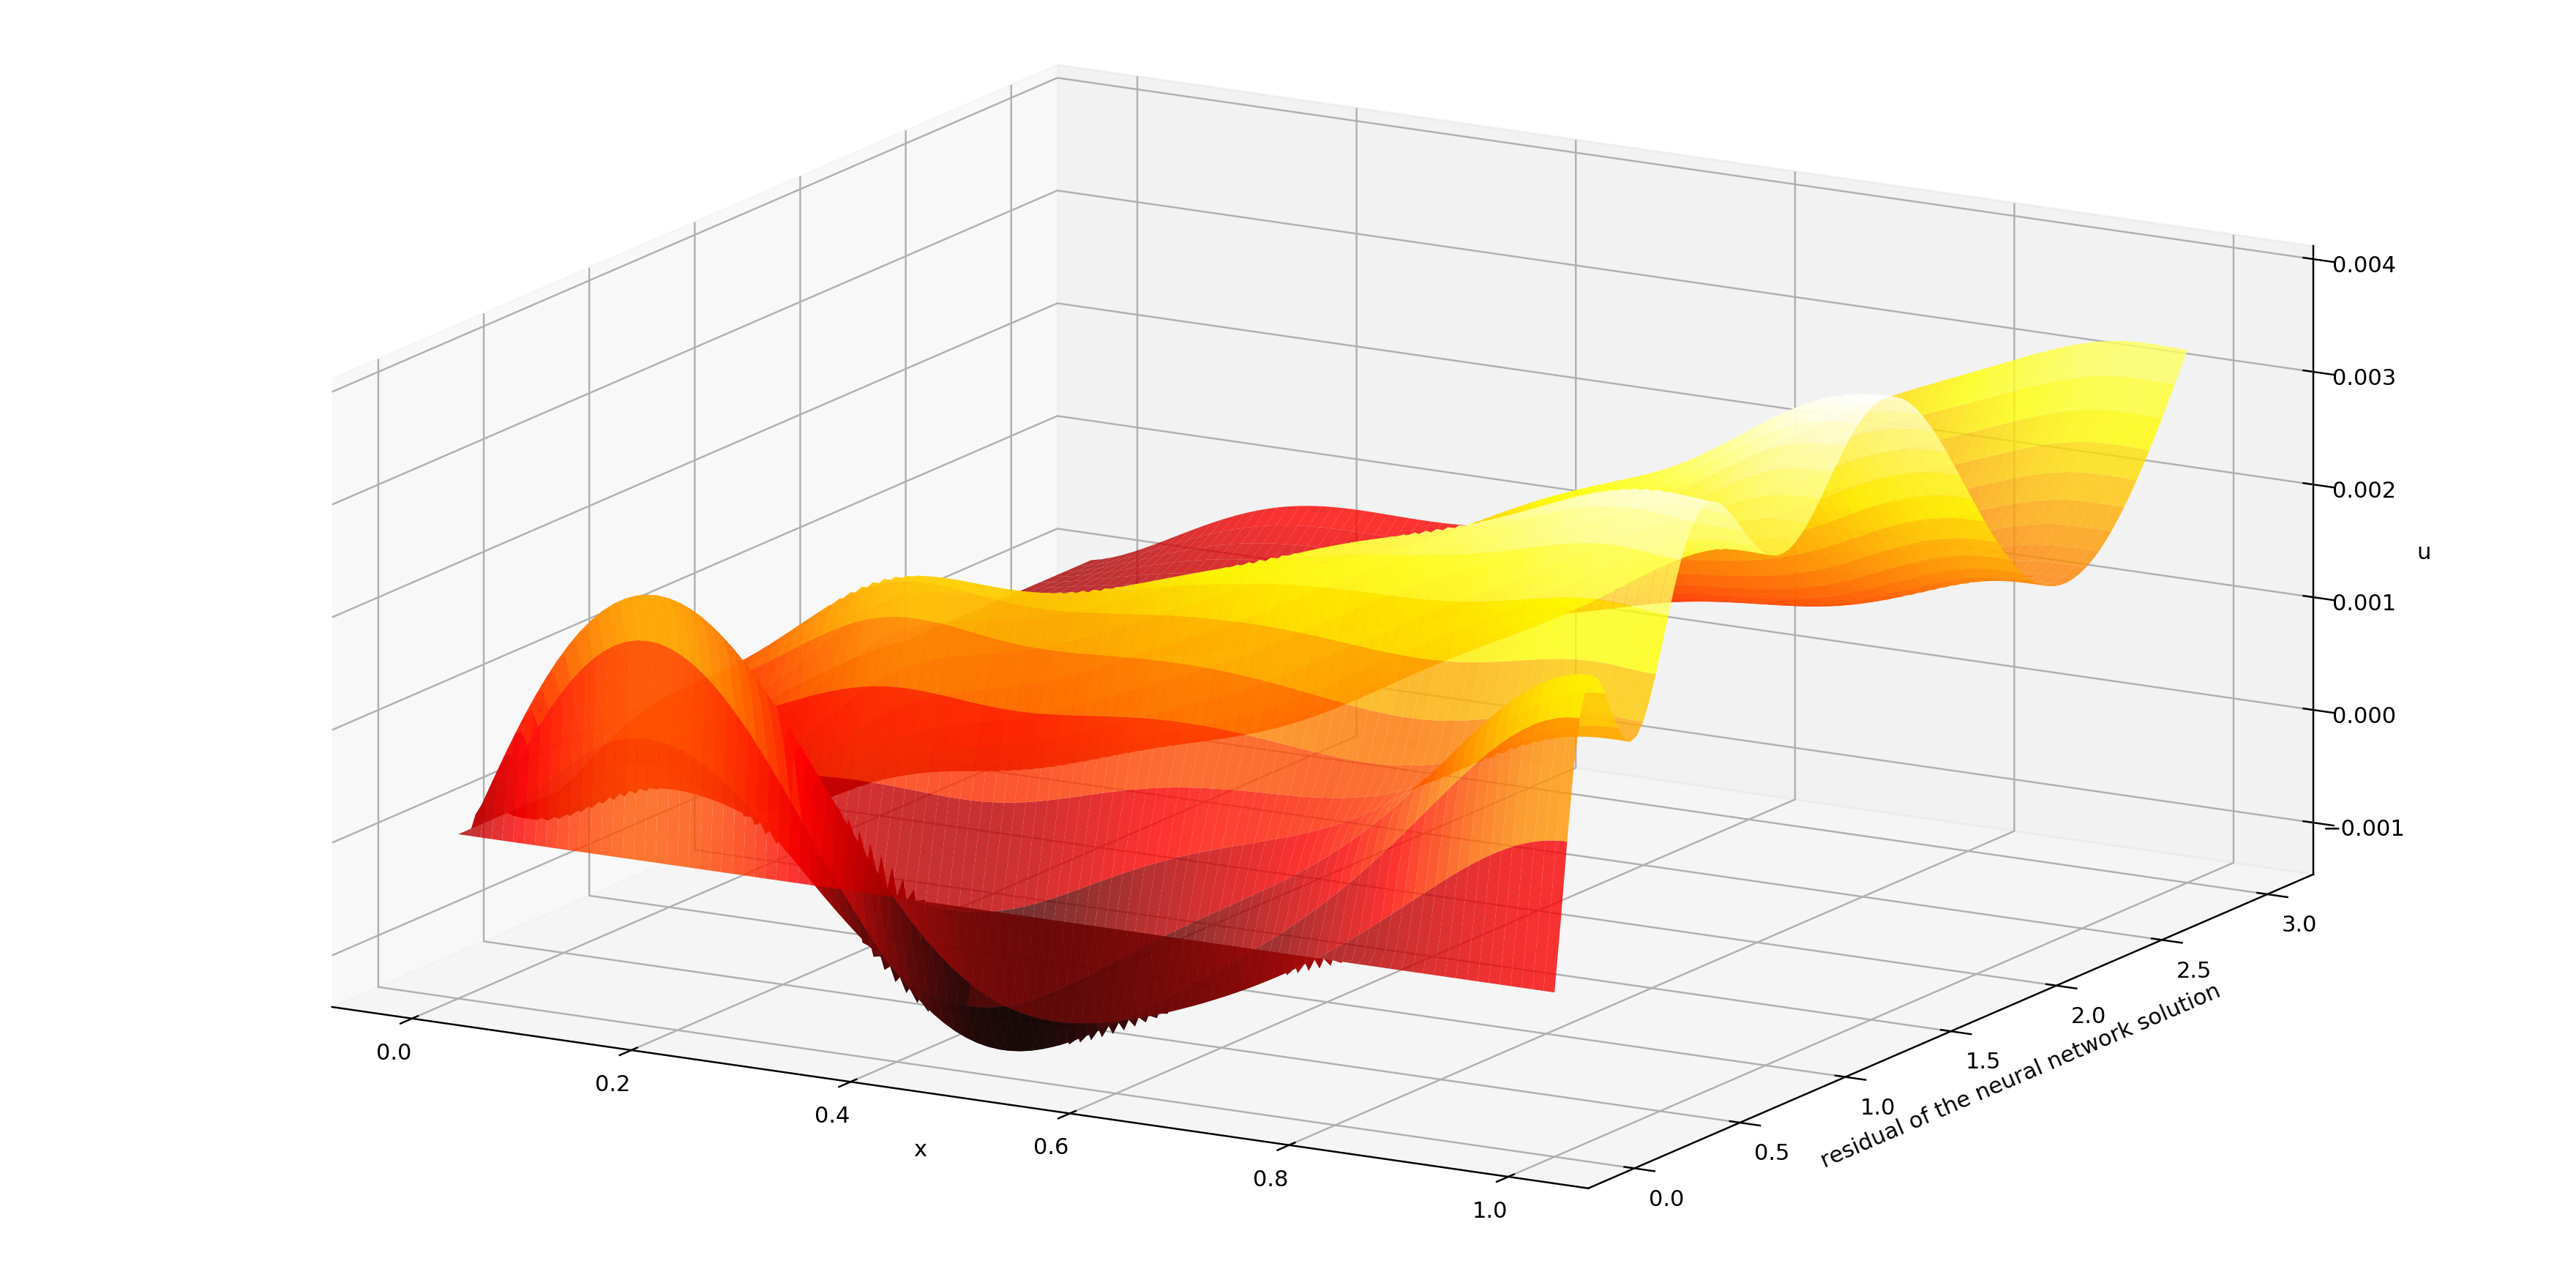

In [25]:
solution_analytical_heat = lambda x, t: np.sin(np.pi*x/L) * np.exp(-k * np.pi**2 * t / L**2)
sol_ana = solution_analytical_heat(xx, tt)
sol_net = solution_neural_net_heat(xx, tt, as_type='np')
plt_surf(xx, tt, sol_net-sol_ana, y_label='residual of the neural network solution')